## Simple EDA to understand the dataset
- whats in our dataset
- what do they look like

In [53]:
import pandas as pd
import numpy as np

In [4]:
%%time
train = pd.read_csv('./data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
# note: this process took 2min 10scs on my computer

CPU times: user 1min 6s, sys: 13.9 s, total: 1min 20s
Wall time: 1min 14s


In [2]:
float_data = pd.read_csv("./data/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

## Calculate aggregated features

## LSTM Using Pytorch

In [54]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [55]:
# we only use mean and std here just for testing at the current stage
def feature_extraction(time_step):
    return np.c_[time_step.mean(axis=1), 
                 np.percentile(np.abs(time_step), q=[0, 25, 50, 75, 100], axis=1).T,
                 time_step.std(axis=1)]

In [56]:
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[feature_extraction(temp),
                 feature_extraction(temp[:, -step_length // 10:]),
                 feature_extraction(temp[:, -step_length // 100:])]

In [57]:
features = create_X(float_data[0:150000]).shape[1]

In [65]:
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=32, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)

In [66]:
print(features)

21


In [67]:
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(None,features)))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN


model.summary()

# Compile and fit model
model.compile(optimizer='rmsprop',loss='mae')



history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=32,
                              verbose=1,
                              validation_data=valid_gen,
                              validation_steps=200
                             )



Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, None, 50)          14400     
_________________________________________________________________
dropout_77 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_78 (LSTM)               (None, None, 50)          20200     
_________________________________________________________________
dropout_78 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_79 (LSTM)               (None, None, 50)          20200     
_________________________________________________________________
dropout_79 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 50)              

dict_keys(['val_loss', 'loss'])


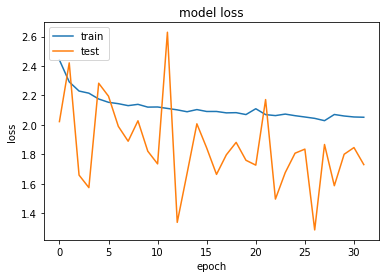

In [69]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("model.h5")
print("Saved model to disk")